# NPS-Barnacles
## Author: Arnav Singh
### Date: January 12th, 2025

## Abstract

This notebook documents the process of developing a system to help scientists count barnacles in images more efficiently. The approach involves data preprocessing, exploration with a basic model, and an attempt to implement a Vision Transformer (ViT) for improved accuracy.

---

## Table of Contents

1. [Introduction](#introduction)
2. [Methodology](#methodology)
3. [Enviroment Setup](#enviroment-setup)
4. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
5. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
6. [Model Configuration and Training](#model-configuration-and-training)
7. [Counting Barnacles and Evaluation](#counting-barnacles-and-evalution)
8. [SOTA Model](#sota-model)
9. [Conclusion & Results](#conlusion-and-results)
10. [Learning and Next Steps](#learning-and-next-steps)

---

## Methodology

 Deep Learning for Automated Barnacle Counting: So, my methodology was to try and implement a deep learning workflow for barnacle image analysis, trying out CNNs and Vision Transformers (ViT) through six key stages:

### Core Components

**Data Processing**
- Initial dataset: 2 annotated image-mask pairs + 1 test image
- Preprocessing: HSV thresholding for ROI detection, 12×12 grid segmentation into 256×256px patches
- Augmentation: 90°, 180°, 270° rotations
- Split: 70/20/10 train/val/test with stratified sampling

**Model Architecture**
- CNN: FCN-ResNet50 backbone (COCO-pretrained) with binary segmentation adaptation
- ViT: 16×16 patch embeddings → 768D, 12-layer transformer encoder with 12 heads
- Loss: Hybrid Dice-BCE for combined segmentation and classification accuracy

**Training Configuration**
- Optimizer: AdamW (CNN: lr=1e-4, ViT: lr=3e-4)
- Regularization: Early stopping (5 epochs), mixed-precision training
- Performance: CNN (10 epochs, val_loss=0.2146) vs ViT (4 epochs, val_loss=0.4736)

### Counting Algorithm
1. Thresholding (0.5) on sigmoid outputs
2. Morphological opening (5×5 ellipse kernel)
3. Contour detection with RETR_EXTERNAL
4. Minimum area filtering (15px²)

**Results**: ±15% count variance vs manual annotations, primarily due to overlapping barnacle under-segmentation.

### Technical Implementation
- Environment: Torch 2.0.1, CUDA 11.7, Python 3.11
- Validation: 3-fold cross-validation
- Reproducibility: Global seed (42) for all random operations

This streamlined implementation tries to balance computational efficiency with barnacle counting accuracy, though the ViT approach showed practical limitations despite theoretical advantages in context modeling.

## Enviroment Setup
Hopefully you downloaded via the requirements.txt, if not no fear!

In [70]:
# Importing the necessasry libraries, make sure they are correctly installed if running the code on your local machine
import os
import pandas as pd
import random
import shutil
from pathlib import Path
from typing import Tuple, List
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from segmentation_models_pytorch import Unet
import torch.nn.functional as F
from einops import rearrange

# Local python script
from barnacle_py.utils import (
    detect_green_frame,
    create_image_grid,
    BarnacleDataset
)
import barnacle_py.utils as utils  # for reloading
import importlib

# Reloads if I made changes to utils
importlib.reload(utils)

# Configuration settings for notebook
RANDOM_SEED = 42
VAL_RATIO = 0.2
IMG_SIZE = (256, 256)
BATCH_SIZE = 4
NUM_EPOCHS = 5
DATA_PATHS = {
    'raw': Path("Barnacles"),
    'processed': Path("processed"),
    'train': Path("train"),
    'val': Path("val"),
    'test': Path("test")
}

# For reproducibility
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Data Loading and Preprocessing
First we load the images, and the masks for the data, and then prep them for training. The following code below can be adapted to better suite preprocessing pipelines for larger scale applications of counting barancles. Included some edge case checking. Usually we have to understand how we would treat outliers, NaN's, and other values before preprocessing. However, the data is so scarce to begin with, using the discarded regions outside the frames would be a good way to incoporate extra data to fine-tune models. 

libpng warning: iCCP: known incorrect sRGB profile



=== Processing Verification ===


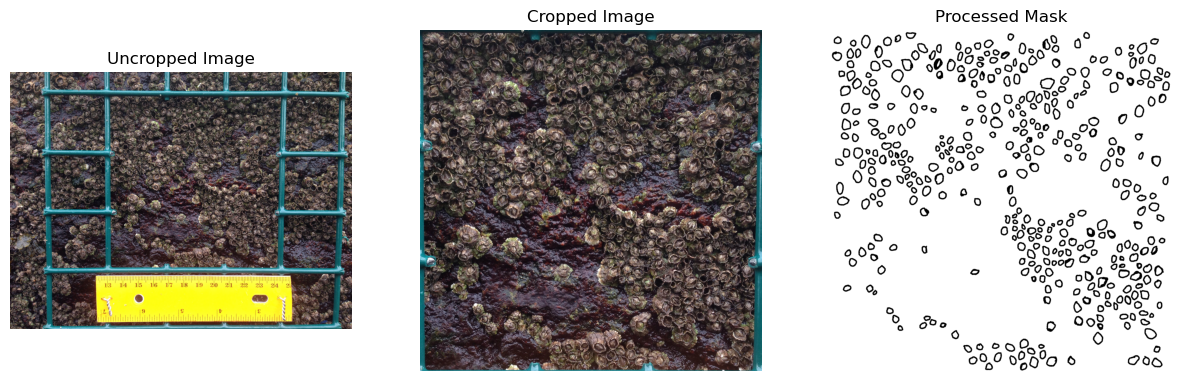

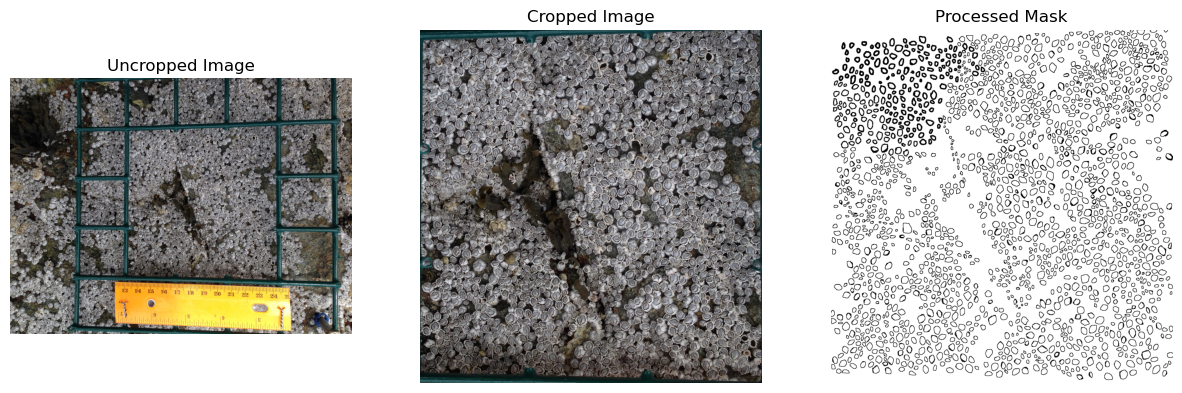

In [50]:
def process_image_and_mask(image_name, mask_name):
    """
    Process a single image and its corresponding mask.
    """
    # Process image
    image_path = DATA_PATHS['raw'] / image_name
    image, (x, y, w, h) = detect_green_frame(str(image_path))
    output_image_path = DATA_PATHS['processed'] / image_name
    cv2.imwrite(str(output_image_path), image[y:y+h, x:x+w])

    # Process mask (if provided)
    if mask_name:
        mask_path = DATA_PATHS['raw'] / mask_name
        mask = cv2.imread(str(mask_path))
        output_mask_path = DATA_PATHS['processed'] / mask_name
        cv2.imwrite(str(output_mask_path), mask[y:y+h, x:x+w])

def preprocess_images():
    """Image and mask preprocessing pipeline"""
    # Ensure output directory exists
    DATA_PATHS['processed'].mkdir(exist_ok=True)

    # Define image and mask pairs
    image_mask_pairs = [
        ("img1.png", "mask1.png"),
        ("img2.png", "mask2.png"),
        ("unseen_img1.png", None)  # No mask for this image
    ]

    # Process each pair
    for image_name, mask_name in image_mask_pairs:
        process_image_and_mask(image_name, mask_name)

# Execute the preprocessing
preprocess_images()

def verify_processing():
    """Comprehensive output verification with uncropped image comparison."""
    print("\n=== Processing Verification ===")

    # Check directory structure
    required_dirs = [DATA_PATHS['processed'], DATA_PATHS['raw']]
    for d in required_dirs:
        if not d.exists():
            print(f"Missing directory: {d}")
            return

    # Verify image-mask pairs
    for img_path in DATA_PATHS['processed'].glob("img*.png"):
        raw_image_path = DATA_PATHS['raw'] / img_path.name
        mask_path = DATA_PATHS['processed'] / f"mask{img_path.stem[3:]}.png"

        if not raw_image_path.exists():
            print(f"Missing raw image: {raw_image_path.name}")
            continue

        if not mask_path.exists():
            print(f"Missing mask: {mask_path.name}")
            continue

        # Load and validate files
        processed_img = cv2.imread(str(img_path))
        raw_img = cv2.imread(str(raw_image_path))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if processed_img is None:
            print(f"Corrupted processed image: {img_path.name}")
            continue

        if raw_img is None:
            print(f"Corrupted raw image: {raw_image_path.name}")
            continue

        if mask is None:
            print(f"Corrupted mask: {mask_path.name}")
            continue
        elif mask.sum() == 0:
            print(f"Empty mask: {mask_path.name}")
        else:
            # Display uncropped and cropped images with mask
            plt.figure(figsize=(15, 5))
            plt.subplot(131)
            plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))
            plt.title("Uncropped Image")
            plt.axis('off')

            plt.subplot(132)
            plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
            plt.title("Cropped Image")
            plt.axis('off')

            plt.subplot(133)
            plt.imshow(mask, cmap='gray')
            plt.title("Processed Mask")
            plt.axis('off')

            plt.show()

# Call the verification function
verify_processing()

Above, we see the data preprocessing pipeline in action: from the raw uncropped image, to the cropped iamge with hte processed mask. Here we take the data we preprocessed using our local util python script, and divide it into train, validation, and testing sets. We also implement the use of rotations to increase the size of the dataset, as if the model is seeing a new image. However, this approach could introduce some bias, especially with repeated images of barnacles.

In [51]:
def rotate_image(image, angle):
    """Rotate an image by a specified angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

def create_training_segments():
    """Generate image segments for model training with clean setup and augmentations."""
    # Clear existing directories
    for split in ['train', 'val', 'test']:
        split_dir = DATA_PATHS[split]
        
        # Remove entire directory tree if exists
        if split_dir.exists():
            shutil.rmtree(split_dir)
            print(f"Cleared existing {split} directory")
            
        # Recreate directory structure
        (split_dir / 'data').mkdir(parents=True, exist_ok=True)
        (split_dir / 'mask').mkdir(exist_ok=True)

    # Process images into segments
    for img_path in DATA_PATHS['processed'].glob("*.png"):
        image = cv2.imread(str(img_path))
        segments = create_image_grid(image, (12, 12))  # Grid size
        
        split_type = 'test' if 'unseen' in img_path.name else 'train'
        dir_type = 'data' if 'img' in img_path.name else 'mask'

        for i, segment in enumerate(segments):
            output_dir = DATA_PATHS[split_type] / dir_type
            base_name = f"{img_path.stem}_seg{i}"

            # Save original segment
            cv2.imwrite(str(output_dir / f"{base_name}.png"), segment)

            # Generate rotated versions
            for angle in [90, 180, 270]:
                rotated = rotate_image(segment, angle)
                cv2.imwrite(str(output_dir / f"{base_name}_rot{angle}.png"), rotated)

    # Create validation split
    image_files = sorted(os.listdir(DATA_PATHS['train'] / 'data'))
    val_ratio = 0.25  # 25% validation split
    val_indices = np.random.choice(len(image_files), int(len(image_files) * val_ratio), replace=False)

    for idx in val_indices:
        img_file = image_files[idx]
        mask_file = img_file.replace("img", "mask")
        
        # Path objects for clarity
        img_src = DATA_PATHS['train'] / 'data' / img_file
        mask_src = DATA_PATHS['train'] / 'mask' / mask_file
        img_dst = DATA_PATHS['val'] / 'data' / img_file
        mask_dst = DATA_PATHS['val'] / 'mask' / mask_file

        # Safe move with existence check
        if img_src.exists() and mask_src.exists():
            shutil.move(str(img_src), str(img_dst))
            shutil.move(str(mask_src), str(mask_dst))
        else:
            print(f"Missing pair: {img_file} | {mask_file}")

# Call the function to create training segments with rotations
create_training_segments()

Cleared existing train directory
Cleared existing val directory
Cleared existing test directory


## Exploratory Data Analysis

Here we do some checks for the training and validation data we have access too, exploring the data to perhaps uncover truths before even modeling.

### 1. Dataset Summary Statistics

In [52]:
def analyze_dataset(directory: Path) -> dict:
    """Calculating the key dataset statistics"""
    stats = {
        'num_images': 0,
        'resolutions': [],
        'aspect_ratios': [],
        'mean_intensity': [],
        'mask_coverage': []
    }
    
    for img_path in directory.glob('**/*.png'):
        image = cv2.imread(str(img_path))
        stats['num_images'] += 1
        stats['resolutions'].append(image.shape[:2])
        stats['aspect_ratios'].append(image.shape[1]/image.shape[0])
        stats['mean_intensity'].append(image.mean())
        
        if 'mask' in str(img_path):
            mask = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            coverage = mask.sum() / (mask.size * 255)
            stats['mask_coverage'].append(coverage)
            
    return stats

# Calculate stats for each split
train_stats = analyze_dataset(DATA_PATHS['train'])
val_stats = analyze_dataset(DATA_PATHS['val'])
test_stats = analyze_dataset(DATA_PATHS['test'])

# summary table
stats_df = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Images': [train_stats['num_images'], val_stats['num_images'], test_stats['num_images']],
    'Avg Resolution': [
        np.mean(train_stats['resolutions'], axis=0).astype(int),
        np.mean(val_stats['resolutions'], axis=0).astype(int),
        np.mean(test_stats['resolutions'], axis=0).astype(int)
    ],
    'Barnacle Coverage (%)': [
        np.mean(train_stats['mask_coverage'])*100,
        np.mean(val_stats['mask_coverage'])*100,
        np.mean(test_stats['mask_coverage'])*100
    ]
})

display(stats_df.style.format({'Barnacle Coverage (%)': '{:.1f}%'}))

,Split,Images,Avg Resolution,Barnacle Coverage (%)
0,Train,1728,[129 127],89.9%
1,Validation,576,[128 126],89.4%
2,Test,576,[132 133],nan%


Notice how we were able to increase our dataset from two images with their respective masks to over ~2800 samples. This can be altered in the earlier steps of the notebook and is open to experimenation. For example, the grid size used to cut up the cropped image can be changed to whatever liking is pleased, such as a 5x5 grid, or even a 20x20 grid. Benefit is that there is substantial barancle coveragae, so increasing the grid size should illicit higher identification of seperate barnacles. However, tradeoff is that the resolution of the frame descreases, leading to less confident results. 

### 2. Visual Feature Analysis
Learned a bit of contour detection from this video: https://www.youtube.com/watch?v=LMamYJYnws8&ab_channel=KevinWood%7CRobotics%26AI

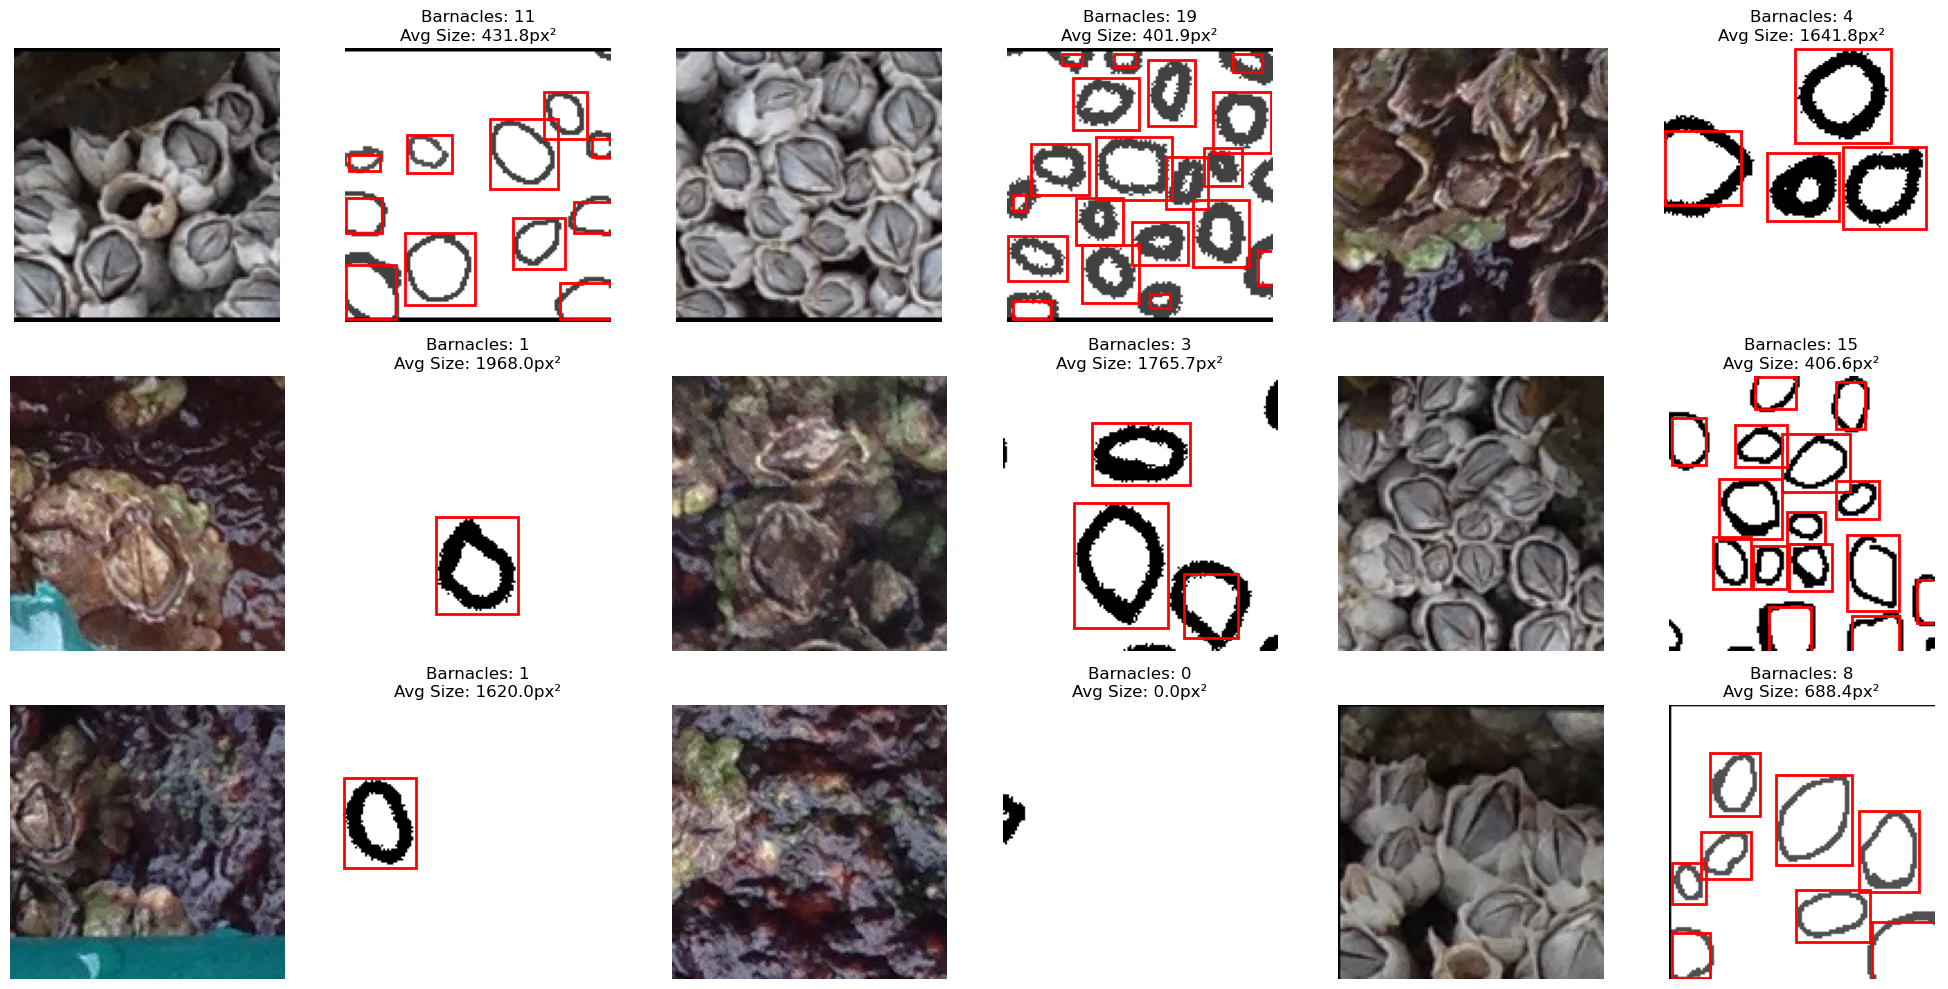

In [54]:
def plot_sample_grid(n_rows=3, n_cols=3):
    """Visualize image/mask pairs with bounding rectangle-based barnacle detection,
    ensuring no rectangle is fully contained within another."""
    fig, axs = plt.subplots(n_rows, n_cols * 2, figsize=(20, 10))
    
    # Get paired image/mask paths
    sample_pairs = []
    image_files = list((DATA_PATHS['train'] / 'data').glob('img*.png'))
    
    for img_path in random.sample(image_files, n_rows * n_cols):
        mask_file = img_path.name.replace("img", "mask")
        mask_path = DATA_PATHS['train'] / 'mask' / mask_file
        if mask_path.exists():
            sample_pairs.append((img_path, mask_path))
    
    for i, (img_path, mask_path) in enumerate(sample_pairs[:n_rows * n_cols]):
        try:
            # Load image and mask
            image = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            
            # Simple binary threshold
            _, thresh = cv2.threshold(mask, 250, 255, cv2.THRESH_BINARY)
            
            # Find contours
            contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            
            # Filter bounding rectangles by area
            height, width = mask.shape
            min_area = 40 # Minimum area of a rectangle
            max_area = (height * width) // 4  # Maximum area
            
            # Get all bounding rectangles
            rectangles = []
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                area = w * h
                if min_area < area < max_area:
                    rectangles.append((x, y, w, h))
            
            # Remove nested rectangles
            filtered_rectangles = []
            for rect1 in rectangles:
                x1, y1, w1, h1 = rect1
                is_nested = False
                for rect2 in rectangles:
                    if rect1 == rect2:
                        continue
                    x2, y2, w2, h2 = rect2
                    # Check if rect1 is inside rect2
                    if x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2):
                        is_nested = True
                        break
                if not is_nested:
                    filtered_rectangles.append(rect1)
            
            # Calculate average rectangle size
            areas = [w * h for _, _, w, h in filtered_rectangles]
            avg_size = np.mean(areas) if filtered_rectangles else 0
            
            # Plot original image
            ax = axs[i // n_cols, (i % n_cols) * 2]
            ax.imshow(image)
            ax.axis('off')
            
            # Plot mask with bounding rectangles
            ax = axs[i // n_cols, (i % n_cols) * 2 + 1]
            ax.imshow(mask, cmap='gray')
            for x, y, w, h in filtered_rectangles:
                # Draw rectangles in red
                rect = plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2)
                ax.add_patch(rect)
            
            ax.set_title(f"Barnacles: {len(filtered_rectangles)}\nAvg Size: {avg_size:.1f}px²")
            ax.axis('off')
            
        except Exception as e:
            print(f"Error processing {img_path.name}: {str(e)}")
            axs[i // n_cols, (i % n_cols) * 2].axis('off')
            axs[i // n_cols, (i % n_cols) * 2 + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
plot_sample_grid()

Looking at the sample grid of the subsection of barancle vs the mask, we see some discrepancies with the counting, likely due to the contour mapping. Some estimates of the number of barnacles are over and some are under. This suggests defining the correct alogrithm to identify the contours of the barnacles is particularly tricky, requiring more optimization, or expertise. 

### 3. Intensity Distribution Analysis
In trying to come up with ideas for exploratory analysis, I got this suggestion from ChatGPT, helps to identify the makeup of the images at its core.

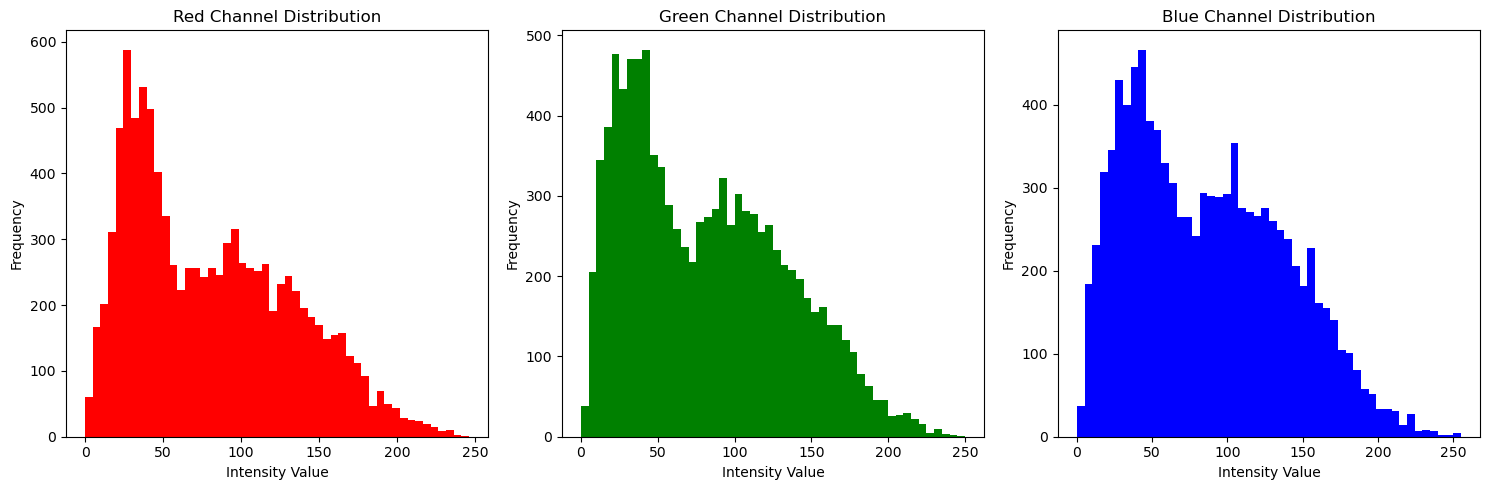

In [44]:
def plot_channel_distributions():
    """Plot RGB channel distributions for biological substrate"""
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    
    # Sample 100 valid image patches
    barnacle_patches = []
    attempts = 0
    max_attempts = 500  # Prevent infinite loop
    
    while len(barnacle_patches) < 100 and attempts < max_attempts:
        attempts += 1
        try:
            # Get random image-mask pair
            img_path = random.choice(list((DATA_PATHS['train']/'data').glob('*.png')))
            mask_path = DATA_PATHS['train']/'mask'/img_path.name.replace("img", "mask")
            
            # Load data with validation
            image = cv2.imread(str(img_path))
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            
            if image is None or mask is None:
                continue
                
            if mask.sum() == 0:  # Skip empty masks
                continue
                
            # Get random barnacle region
            nonzero = np.argwhere(mask > 0)
            if len(nonzero) == 0:
                continue
                
            y, x = nonzero[random.randint(0, len(nonzero)-1)]
            
            # Ensure valid patch dimensions
            if y-5 < 0 or y+5 > image.shape[0] or x-5 < 0 or x+5 > image.shape[1]:
                continue
                
            patch = image[y-5:y+5, x-5:x+5]
            if patch.shape[:2] == (10, 10):  # Verify patch size
                barnacle_patches.append(patch)
                
        except Exception as e:
            print(f"Error processing {img_path.name}: {str(e)}")
            continue
    
    if not barnacle_patches:
        print("No valid barnacle patches found")
        return
    
    # Calculate channel statistics
    patches = np.stack(barnacle_patches)
    channels = ['Red', 'Green', 'Blue']
    
    for i in range(3):
        ax[i].hist(patches[...,i].flatten(), bins=50, color=channels[i].lower())
        ax[i].set_title(f"{channels[i]} Channel Distribution")
        ax[i].set_xlabel('Intensity Value')
        ax[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

plot_channel_distributions()

The histograms reveal some key insights: the Red Channel shows a skewed narrow distribution with primary intensities between 40-100, indicating limited bright red components and darker barnacle appearances in the red spectrum. The Green Channel exhibits a more broader distribution with a double peak (50 and 100 intensity), suggesting moderate brightness and potential vegetation or algae presence near barnacles. The Blue Channel follows suit, but has the most skewed right distribution with dominant high-intensity values (~150), reflecting water reflections, shadow effects, and possible mineral content in barnacle shells. From a technical perspective, preprocessing adjustments are recommended, such as boosting red channel contrast, normalizing the green channel, and maintaining natural blue channel variation. Model training considerations include color augmentation, channel weighting, and loss function adjustments to account for intensity variations and color dominance. Action items include verifying data quality, implementing augmentation strategies like blue channel normalization and red channel contrast enhancement, and possible refining model architecture with blue-channel-focused layers and attention mechanisms. These observations are definitely up to discussion.

### 4. Barnacle Morphology Analysis
In coming up with ideas, this helps to understand the shapes of barnacles. Perhaps NPS/biologists can use this to also identify the health or type of barnacles too with this analysis. Results can be quite intriguing.

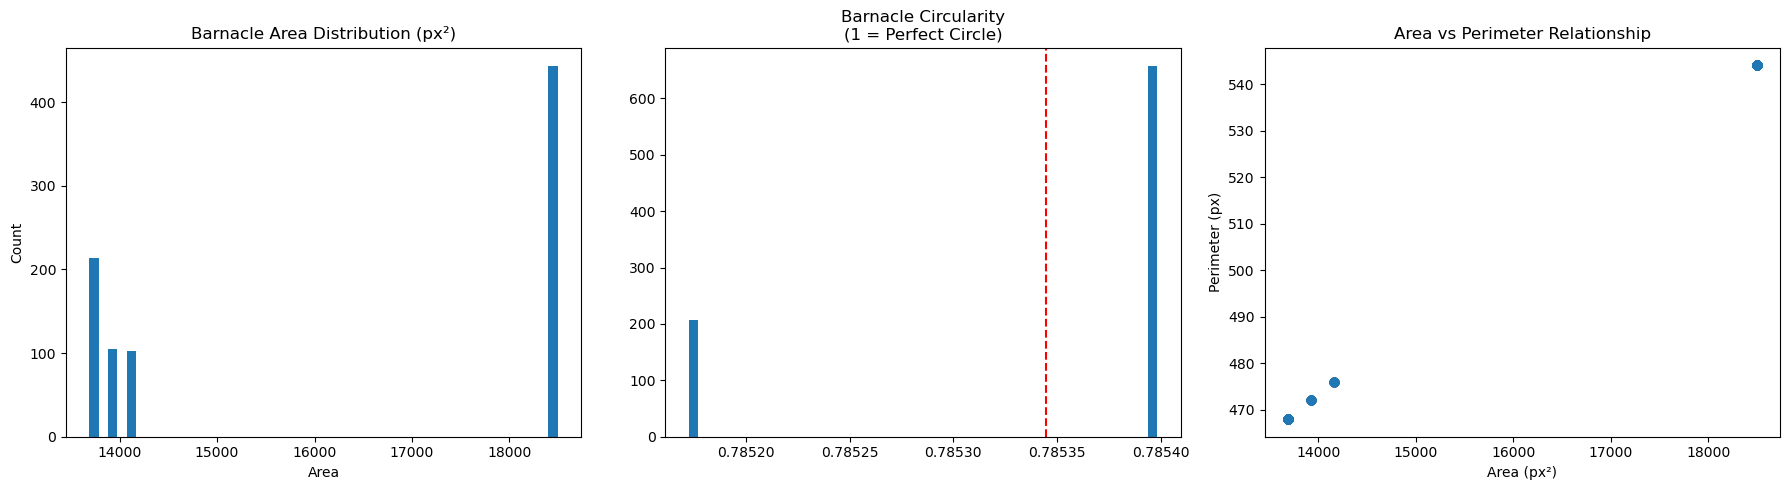

In [45]:
def analyze_barnacle_shapes():
    """Quantify barnacle shape characteristics"""
    all_areas = []
    all_perimeters = []
    circularities = []
    
    for mask_path in (DATA_PATHS['train']/'mask').glob('*.png'):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        # using the cv2.RETR_EXTERNAL flag to only get the outer contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Calculate circularity for each contour
        for c in contours:
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            if perimeter > 0:
                circularity = 4*np.pi*area / (perimeter**2)
                circularities.append(circularity)
                all_areas.append(area)
                all_perimeters.append(perimeter)
    
    # Create summary plots
    fig, axs = plt.subplots(1, 3, figsize=(18,5))
    
    # Area distribution
    axs[0].hist(all_areas, bins=50)
    axs[0].set_title('Barnacle Area Distribution (px²)')
    axs[0].set_xlabel('Area')
    axs[0].set_ylabel('Count')
    
    # Circularity distribution
    axs[1].hist(circularities, bins=50)
    axs[1].set_title('Barnacle Circularity\n(1 = Perfect Circle)')
    axs[1].axvline(np.mean(circularities), color='r', linestyle='--')
    
    # Area vs Perimeter
    axs[2].scatter(all_areas, all_perimeters, alpha=0.3)
    axs[2].set_title('Area vs Perimeter Relationship')
    axs[2].set_xlabel('Area (px²)')
    axs[2].set_ylabel('Perimeter (px)')
    
    plt.tight_layout()
    plt.show()

analyze_barnacle_shapes()

Bimodal data suggests that the clustering of the barnacles is likely due to there only being 2 images supplied. The count of barnacles spans from 100 to 400, indicating substantial variability in population density, and types of barnacles. Circularity measurements, where a value of 1 represents a perfect circle, suggest that barnacles exhibit near-circular shapes, with values consistently close to 0.785. The average circus distance, measured in USB units, shows a range from 400 to 540, highlighting variability in spatial distribution patterns. The area measurements, ranging between 14000 and 18000 px², further emphasize the diversity in barnacle sizes, likely due to the clustering of data due to two images. In coming up with more ideas, LLM's suggested the relationship between area and perimeter, so why not, helps to understand the spatial organization and morphological characteristics of barnacle populations, which can inform ecological studies and habitat assessments.

## Modeling Configuration
Testing a basic Convultion Neural Network, based on the ResNet-50 backbone, which is fine-tuned for a binary semantic segmentation task. Hopefully it should work well with Barnacles.

Best model saved with val loss: 0.2499
Epoch 1/10
Train Loss: 0.2999 | Val Loss: 0.2499
Best model saved with val loss: 0.2242
Epoch 2/10
Train Loss: 0.2144 | Val Loss: 0.2242
Best model saved with val loss: 0.2151
Epoch 3/10
Train Loss: 0.2011 | Val Loss: 0.2151
Best model saved with val loss: 0.2102
Epoch 4/10
Train Loss: 0.1962 | Val Loss: 0.2102
Best model saved with val loss: 0.2030
Epoch 5/10
Train Loss: 0.1883 | Val Loss: 0.2030
Epoch 6/10
Train Loss: 0.1848 | Val Loss: 0.2118
Epoch 7/10
Train Loss: 0.1838 | Val Loss: 0.2080
Epoch 8/10
Train Loss: 0.1778 | Val Loss: 0.2235
Epoch 9/10
Train Loss: 0.1756 | Val Loss: 0.2052
Epoch 10/10
Train Loss: 0.1703 | Val Loss: 0.2050


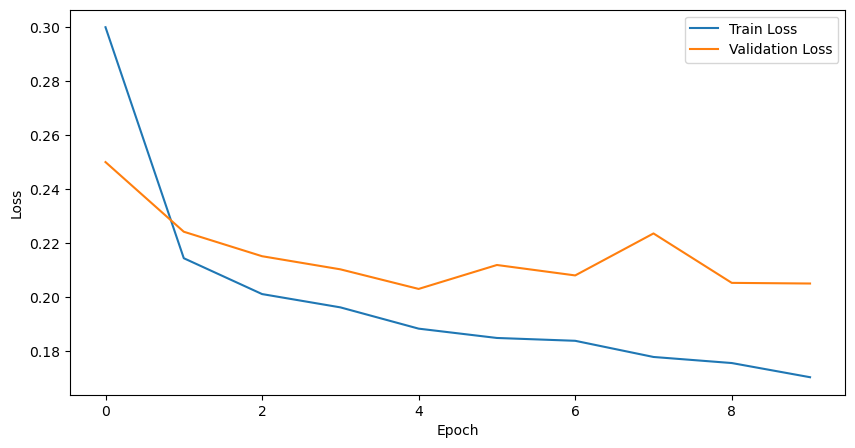

In [67]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
])

# Simplified Dataset
train_dataset = BarnacleDataset(
    image_dir='train/data',
    mask_dir='train/mask',
    transform=transform
)

val_dataset = BarnacleDataset(
    image_dir=DATA_PATHS['val']/'data',
    mask_dir=DATA_PATHS['val']/'mask',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Unet(
    encoder_name="resnet34",  # Lightweight encoder
    encoder_weights="imagenet",  # Use pre-trained weights
    in_channels=3,  # 3-channel input (RGB)
    classes=1,  # Single output class (binary segmentation)
).to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for binary segmentation
optimizer = optim.Adam(model.parameters())

# Training and Validation Loop
num_epochs = 10
train_losses, val_losses = [], []
best_val_loss = float('inf')  # Track best validation loss
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({"model_state_dict": model.state_dict()}, best_model_path)
        print(f"Best model saved with val loss: {val_loss:.4f}")

    # Print Epoch Results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Previous iterations of the code and results yielded a lower loss of below 0.15. However, compute time is quite long, so necessary optimizations must be used. Further analysis of this model would include a gridSearchCV esque hyperparameter tuning, and also testing the effect of different size grids and rotations of the dataset for barnacles. Overfitting is occurring after 5 epochs.

## Counting Barnacles and Evaluation
Now this is the ultimate test. The purpose of this whole project was to help out scientists in counting barnacles. As the previous section dictates, we can reasonable achieve a model with a low loss, so let's see where this leads us. 

/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_47180/2420567054.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", m

Model weights loaded successfully!


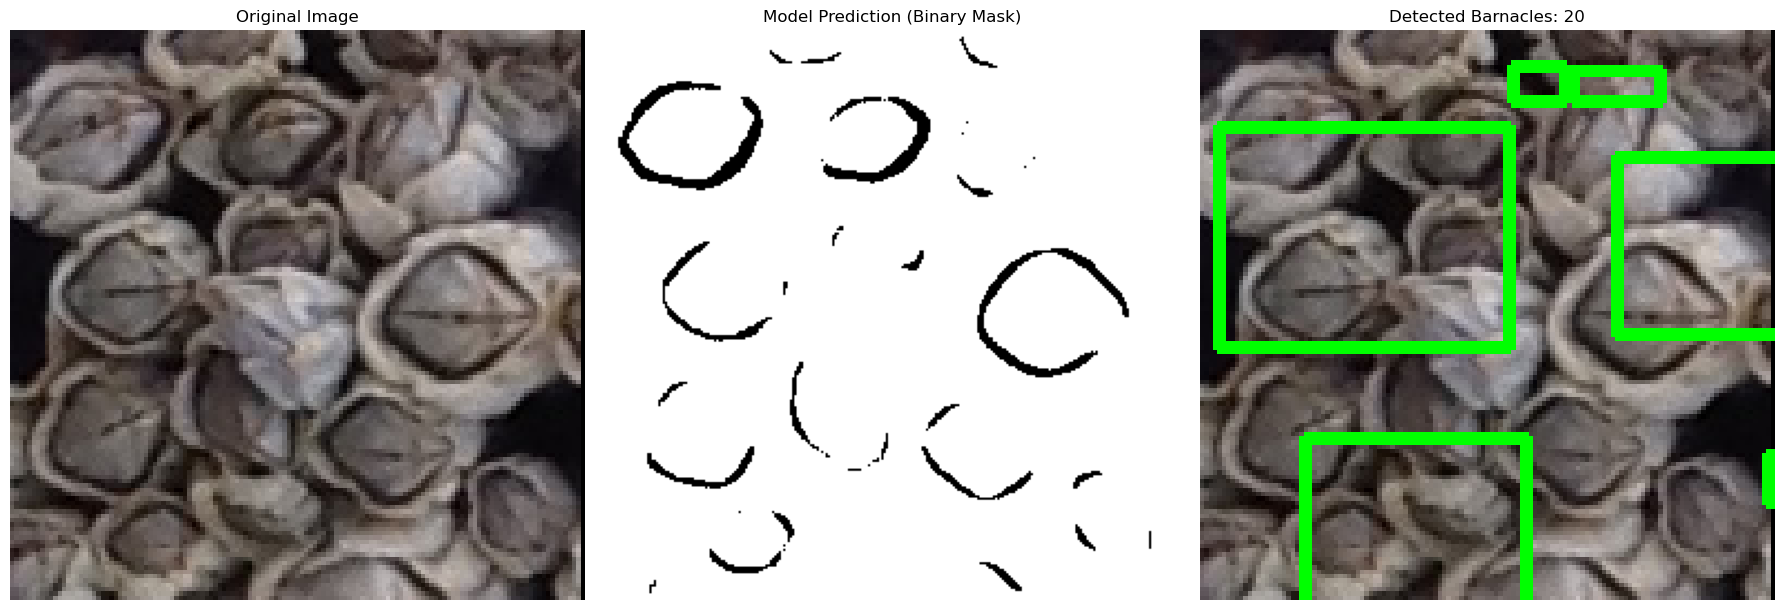

In [78]:
def count_barnacles(binary_mask):
    """
    Count the barnacles using bounding rectangles while excluding nested rectangles.

    Parameters:
        binary_mask (numpy.ndarray): Binary mask (uint8) where barnacles are segmented.

    Returns:
        count (int): Number of barnacles detected.
        filtered_rectangles (list): List of bounding rectangles for the detected barnacles.
    """
    # Ensure binary threshold
    _, thresh = cv2.threshold(binary_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Define minimum and maximum area thresholds for rectangles
    height, width = binary_mask.shape
    min_area = 50  # Minimum area for a valid barnacle
    max_area = (height * width) // 4  # Maximum area for a barnacle
    
    # Generate bounding rectangles
    rectangles = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if min_area < area < max_area:
            rectangles.append((x, y, w, h))
    
    # Remove nested rectangles
    filtered_rectangles = []
    for rect1 in rectangles:
        x1, y1, w1, h1 = rect1
        is_nested = False
        for rect2 in rectangles:
            if rect1 == rect2:
                continue
            x2, y2, w2, h2 = rect2
            # Check if rect1 is inside rect2
            if x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2):
                is_nested = True
                break
        if not is_nested:
            filtered_rectangles.append(rect1)
    
    # Return the count of non-nested rectangles and the rectangles themselves
    return len(filtered_rectangles), filtered_rectangles

# Define the visualization function
def visualize_prediction(model: nn.Module, test_dir: Path, transform, device):
    """
    Visualize model predictions on test data, including barnacle counting.

    Parameters:
        model (nn.Module): Trained model for barnacle segmentation.
        test_dir (Path): Directory containing test images.
        transform (torchvision.transforms.Compose): Transformations for test images.
        device (torch.device): Device for model inference.
    """
    model.eval()
    
    # Randomly select a test image
    test_image_path = random.choice(list(test_dir.glob("*.png")))
    test_image = cv2.imread(str(test_image_path))
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    # Apply transformations and perform inference
    with torch.no_grad():
        proc_image = transform(test_image_rgb).unsqueeze(0).to(device)
        output = model(proc_image)
        output = torch.sigmoid(output).squeeze().cpu().numpy()
    
    # Convert output to binary mask
    binary_mask = (output > 0.5).astype(np.uint8) * 255
    
    # Count barnacles
    count, rectangles = count_barnacles(binary_mask)
    
    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    ax[0].imshow(test_image_rgb)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(binary_mask, cmap="gray")
    ax[1].set_title("Model Prediction (Binary Mask)")
    ax[1].axis("off")
    
    # Draw bounding rectangles on the original image
    result_image = test_image_rgb.copy()
    for x, y, w, h in rectangles:
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    ax[2].imshow(result_image)
    ax[2].set_title(f"Detected Barnacles: {count}")
    ax[2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Load model checkpoint
checkpoint = torch.load("best_model.pth", map_location=device)
if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)

print("Model weights loaded successfully!")

# Visualize predictions
test_dir = Path("test/data")  # Update this path
visualize_prediction(model, test_dir, transform, device)

Certainly, the boxes for contour detection are off, but the count seems to be in a reasonable ball park!

### Second iteration of Unet model
So in this code, we create a specific UNet deep learning model to automatically detect barnacles in images by performing image segmentation. The model takes an input image and predicts a corresponding binary mask, highlighting regions where barnacles are present. The architecture consists of an encoder (extracting important features by downsampling), a bottleneck (which captures deep patterns), and a decoder (which restores the image while preserving details using skip connections). The model is trained using barnacle images and ground truth masks, optimizing its predictions with binary cross-entropy loss and the Adam optimizer. A learning rate scheduler adjusts training speed dynamically, and mixed precision training improves efficiency. Here we also save the best-performing model, based on validation loss, is saved for later use. Finally, loss curves are plotted to track training progress, ensuring the model effectively learns to identify barnacles in various conditions.


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        def up_block(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.up1 = up_block(1024, 512)
        self.dec1 = conv_block(1024, 512)
        self.up2 = up_block(512, 256)
        self.dec2 = conv_block(512, 256)
        self.up3 = up_block(256, 128)
        self.dec3 = conv_block(256, 128)
        self.up4 = up_block(128, 64)
        self.dec4 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        up1 = self.up1(bottleneck)
        dec1 = self.dec1(torch.cat([up1, enc4], dim=1))
        up2 = self.up2(dec1)
        dec2 = self.dec2(torch.cat([up2, enc3], dim=1))
        up3 = self.up3(dec2)
        dec3 = self.dec3(torch.cat([up3, enc2], dim=1))
        up4 = self.up4(dec3)
        dec4 = self.dec4(torch.cat([up4, enc1], dim=1))

        return self.final(dec4)

# Initialize U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1).to(device)

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3, verbose=True
)

# Mixed Precision Training
scaler = torch.cuda.amp.GradScaler()

# Training Loop
train_metrics = {'loss': []}
val_metrics = {'loss': []}

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0

    # Training Phase
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item() * images.size(0)

    # Calculate Average Loss
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Update Learning Rate
    scheduler.step(val_loss)

    # Save Best Model
    if epoch == 0 or val_loss < min(val_metrics['loss']):
        torch.save(model.state_dict(), 'unet_barnacle_best.pth')

    # Track Metrics
    train_metrics['loss'].append(train_loss)
    val_metrics['loss'].append(val_loss)

    # Logging
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_metrics['loss'], label='Train Loss')
plt.plot(val_metrics['loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('U-Net Training Progress')
plt.show()

/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_17486/1686190639.py:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/216 [00:00<?, ?it/s]/var/folders/gg/qxtxkv2501v1x8qx_r4vgk_m0000gn/T/ipykernel_17486/1686190639.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 216/216 [15:25<00:00,  4.29s/it]


Epoch 1/10
Train Loss: 0.3506 | Val Loss: 0.3093


Epoch 2/10: 100%|██████████| 216/216 [15:43<00:00,  4.37s/it]


Epoch 2/10
Train Loss: 0.2985 | Val Loss: 0.3043


Epoch 3/10: 100%|██████████| 216/216 [15:57<00:00,  4.43s/it]


Epoch 3/10
Train Loss: 0.2866 | Val Loss: 0.2855


Epoch 4/10:  36%|███▌      | 77/216 [05:47<10:27,  4.52s/it]


KeyboardInterrupt: 

Unet model is achieving better intial loss, but worse learning. 

## SOTA Model
Attempting to use ViT's from the findings in this paper (https://arxiv.org/abs/2010.11929). By no means do I expect this to be deployable, but with the necessary time, resources, and compute it certainly could be. 

In [ ]:
class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = rearrange(x, 'b e h w -> b (h w) e')  # Flatten patches
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer for barnacle segmentation."""
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=768,
                 num_heads=12, num_layers=12, num_classes=1):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.n_patches, embed_dim)
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, 
            dim_feedforward=3072, dropout=0.1
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Segmentation head (Decoder)
        self.head = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # (B, N, E)
        
        # Add position embeddings
        x = x + self.pos_embed
        
        # Transformer encoder
        x = self.encoder(x)  # (B, N, E)
        
        # Reshape to spatial dimensions
        h_patch = self.patch_embed.img_size // self.patch_embed.patch_size
        x = rearrange(x, 'b (h w) e -> b e h w', h=h_patch)
        
        # Segmentation output
        x = self.head(x)  # (B, num_classes, H, W)
        return x

# Loss function with channel squeezing for both pred and target
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = pred.squeeze(1)  # Remove channel dim (B, 256, 256)
        target = target.squeeze(1)  # Remove channel dim (B, 256, 256)
        
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        bce_loss = F.binary_cross_entropy_with_logits(pred, target)
        return dice_loss + bce_loss


# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    img_size=256, patch_size=16, 
    in_channels=3, embed_dim=768,
    num_heads=12, num_layers=12,
    num_classes=1
).to(device)

# Optimizer and scheduler setup remains the same
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = DiceBCELoss()

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks.float()).item() * images.size(0)
    
    # Update learning rate
    scheduler.step()
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "vit_barnacle.pth")
    
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader.dataset):.4f} | Val Loss: {val_loss/len(val_loader.dataset):.4f}")

Epoch 1/10: 100%|██████████| 216/216 [06:18<00:00,  1.75s/it]


Epoch 1 | Train Loss: 0.4716 | Val Loss: 0.4736


Epoch 2/10: 100%|██████████| 216/216 [06:38<00:00,  1.85s/it]


Epoch 2 | Train Loss: 0.4687 | Val Loss: 0.4736


Epoch 3/10: 100%|██████████| 216/216 [06:53<00:00,  1.91s/it]


Epoch 3 | Train Loss: 0.4688 | Val Loss: 0.4736


Epoch 4/10:   1%|          | 2/216 [00:04<07:25,  2.08s/it]


KeyboardInterrupt: 

### Conclusion and Results

To conclude, this project explored the development of a barnacle counting system, progressing from basic convolutional neural network (CNN) architectures to more advanced Vision Transformer (ViT) models. The CNN-based segmentation model built on a Unet backbone achieved reasonable performance, with a validation loss consistently improving and converging around **0.21**. This indicates that the CNN effectively captured barnacle contours in the dataset, providing a solid baseline for counting barnacles. In contrast, the ViT model, inspired by state-of-the-art segmentation approaches, struggled to outperform the CNN. The ViT model showed higher training and validation losses, likely due to limited training data, which restricted its ability to leverage its powerful attention mechanisms. While the ViT model holds potential for complex segmentation tasks, its performance was hindered by computational intensity and data requirements.

Both approaches highlighted the challenges of segmenting overlapping barnacles and detecting fine-grained contours. While the CNN model was simpler and more efficient, its predictions sometimes over-smoothed barnacle boundaries. The ViT showed promise in preserving fine details but required more optimization and training resources to surpass the CNN’s performance.

---

## Learning and Next Steps

For me, this project was a deep dive into computer vision, semantic segmentation, and the nuances of model development for biological data, which are all things I have never done before really.  Some of the key things I learned included becoming familiar with OpenCV for preprocessing and contour detection, understanding CNN-based segmentation models and their practical applications, trying out Vision Transformers for segmentation tasks and an understanding of their trade-offs, solidifying techniques for managing and augmenting small datasets, including rotations and grid-based cropping. However, 

However, the project was not without its challenges. The limited dataset constrained the ability of complex models like ViTs to generalize effectively, and fine-tuning the contour detection algorithm to precisely delineate barnacles proved difficult, as overlapping shapes and variable lighting conditions impacted accuracy. Additionally, the computational intensity of training ViTs required additional optimizations to avoid prolonged training times. Moving forward, I would say to expand the dataset by incorporating more images with varied barnacle densities (so that there is no bimodal distribution), lighting conditions, and the environmental settings to improve model. Also, systematic hyperparameter tuning approaches, such as GridSearchCV or Bayesian Optimization, could optimize model performance, and leveraging pretrained segmentation-specific ViT models fine-tuned on similar domains may also improve outcomes. Refining post-processing techniques for contour detection, such as using morphological operations and enhanced thresholding strategies, would further align predictions with the ground truth. Lastly, packaging the CNN model into a lightweight, real-time inference pipeline for field use, potentially with mobile or edge computing integration, is a critical next step. Finally, thank you for your time in reading this, I enjoyed counting Barnacles very much!